In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import random
import re
import nltk
import string
from sklearn.model_selection import train_test_split
import transformers
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import MobileBertTokenizer, TFMobileBertForSequenceClassification


In [ ]:
df = pd.read_csv("sentiment.csv")

In [ ]:
np.unique(df['sentiment'].to_numpy())

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
from keras.utils import to_categorical
data = df[['text','sentiment']]
classes = ["Negative", "Neutral", "Positive"]
labels = [classes.index(x) for x in df['sentiment']]

In [ ]:
# Preprocessing

data['text'] = data['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['text'] = data['text'].str.replace('rt','')
data['text']



<ipython-input-25-822dcf4f94ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: x.lower())
<ipython-input-25-822dcf4f94ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
<ipython-input-25-822dcf4f94ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

0         nancyleegrahn how did everyone feel about the...
1         scottwalker didnt catch the full gopdebate la...
2         tjmshow no mention of tamir rice and the gopd...
3         robgeorge that carly fiorina is trending  hou...
4         danscavino gopdebate w realdonaldtrump delive...
                               ...                        
13866     cappy_yarbrough love to see men who will neve...
13867     georgehenryw who thought huckabee exceeded th...
13868     lrihendry tedcruz as president i will always ...
13869     jrehling gopdebate donald trump says that he ...
13870     lrihendry tedcruz headed into the presidentia...
Name: text, Length: 13871, dtype: object

In [ ]:
data.head()

,text,sentiment
0,nancyleegrahn how did everyone feel about the...,Neutral
1,scottwalker didnt catch the full gopdebate la...,Positive
2,tjmshow no mention of tamir rice and the gopd...,Neutral
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive


In [ ]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("english"))

# https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#data["text"] = data.text.map(remove_stopwords)

In [ ]:
x=list(data['text'])
y=list(labels)
data['sentiment']=list(data['sentiment'])
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2,stratify=y)


<ipython-input-29-2f4c4475ec63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment']=list(data['sentiment'])


In [ ]:
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained("vumichien/emo-mobilebert")


In [ ]:
def convert_example_to_feature(review):
  return mobilebert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )

In [ ]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
batch_size = 8
# train dataset
ds_train = zip(X_train, y_train)
ds_test = zip(X_val, y_val)
ds_train_encoded = encode_examples(ds_train).shuffle(len(X_train)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [ ]:
# bert_model =  TFBertForSequenceClassification.from_pretrained(
#     'bert-base-uncased', num_labels=3)
# #bert_model.bert.trainable = False
# bert_model.summary()
mobile_bert_model = TFMobileBertForSequenceClassification.from_pretrained("vumichien/emo-mobilebert")

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.3M [00:00<?, ?B/s]

Some layers from the model checkpoint at vumichien/emo-mobilebert were not used when initializing TFMobileBertForSequenceClassification: ['dropout_989']
- This IS expected if you are initializing TFMobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFMobileBertForSequenceClassification were initialized from the model checkpoint at vumichien/emo-mobilebert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMobileBertForSequenceClassification for predictions without further training.


In [ ]:
mobile_bert_model.summary()

Model: "tf_mobile_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMai  multiple                 21195776  
 nLayer)                                                         
                                                                 
 dropout_49 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2052      
                                                                 
Total params: 21,197,828
Trainable params: 21,197,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 8

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

mobile_bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [ ]:
history=mobile_bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/8
1387/1387 [==============================] - 809s 545ms/step - loss: 0.9149 - accuracy: 0.6085 - val_loss: 0.8549 - val_accuracy: 0.6187
Epoch 2/8
1387/1387 [==============================] - 748s 539ms/step - loss: 0.8066 - accuracy: 0.6415 - val_loss: 0.7882 - val_accuracy: 0.6551
Epoch 3/8
1387/1387 [==============================] - 741s 534ms/step - loss: 0.7510 - accuracy: 0.6686 - val_loss: 0.7723 - val_accuracy: 0.6580
Epoch 4/8
1387/1387 [==============================] - 737s 531ms/step - loss: 0.7172 - accuracy: 0.6863 - val_loss: 0.7624 - val_accuracy: 0.6695
Epoch 5/8
1387/1387 [==============================] - 738s 532ms/step - loss: 0.6922 - accuracy: 0.6984 - val_loss: 0.7646 - val_accuracy: 0.6717
Epoch 6/8
1387/1387 [==============================] - 737s 531ms/step - loss: 0.6708 - accuracy: 0.7098 - val_loss: 0.7742 - val_accuracy: 0.6703
Epoch 7/8
1387/1387 [==============================] - 739s 532ms/step - loss: 0.6555 - accuracy: 0.7203 - val_loss: 0

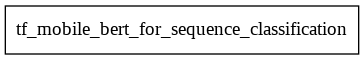

In [ ]:
tf.keras.utils.plot_model(mobile_bert_model)

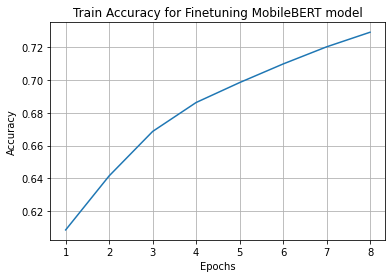

In [ ]:
import matplotlib.pyplot as plt
# loss_train = history.history['loss']
# loss_val = history.history['val_loss']
# epochs = range(1,9)
# plt.plot(epochs, loss_train, 'g', label='Training loss')
# plt.plot(epochs, loss_val, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

epochs = range(1,9)
plt.plot(epochs, history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy for Finetuning MobileBERT model")
plt.grid("on")
plt.savefig("mobilebert-finetune-accuracy.png")

In [ ]:
mobile_bert_model.save_weights('mobile_bert.h5')